In [ ]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [ ]:
df = pd.read_csv('data/medicalmalpractice.csv')

In [ ]:
# Show top 5 record
df.head()

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female


In [ ]:
# # Feature Engineering
# # Create Age Group
# df['Age Group'] = pd.cut(df['Age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '80+'])

# # Create Severity Category
# df['Severity Category'] = pd.cut(df['Severity'], bins=[1, 3, 6, 9], labels=['Low', 'Medium', 'High'])

# # Create Interaction Term
# df['Attorney_Severity'] = df['Private Attorney'] * df['Severity']

#### Preparing X and Y variables

In [ ]:
X = df.drop(columns=['Amount'],axis=1)

In [ ]:
X.head()

,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,7,62,1,2,Family Practice,Private,Male
1,6,38,1,2,OBGYN,No Insurance,Female
2,4,34,1,2,Cardiology,Unknown,Male
3,7,42,1,1,Pediatrics,No Insurance,Female
4,3,60,0,2,OBGYN,Medicare/Medicaid,Female


In [ ]:
y = df['Amount']

In [ ]:
y

0         57041
1        324976
2        135383
3        829742
4        197675
          ...  
79205     25305
79206     43098
79207     35398
79208    154228
79209    168298
Name: Amount, Length: 79210, dtype: int64

In [ ]:
# create column Transformer with 3 types of transformers

# Handling categorical features
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Fit OneHotEncoder separately to get feature names
oh_transformer = OneHotEncoder()
oh_transformer.fit(X[cat_features])
ohe_feature_names = oh_transformer.get_feature_names_out(cat_features).tolist()

# Define the full preprocessor
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [ ]:
# X = preprocessor.fit_transform(X)
# Fit the preprocessor and convert to DataFrame
X_transformed = preprocessor.fit_transform(X).toarray()
transformed_feature_names = ohe_feature_names + num_features.tolist()

# Convert transformed data to DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)

In [ ]:
X_transformed_df.shape

(79210, 31)

In [ ]:
# Seperate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((63368, 31), (15842, 31))

#### Create an Evaluate Function to give all metrics after model Training

In [ ]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
# Train and Evaluate Multiple Models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

# Results
results_df = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 160790.8739
- Mean Absolute Error: 111897.3776
- R2 Score: 0.3027
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 162754.6441
- Mean Absolute Error: 113591.1672
- R2 Score: 0.3063




c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.978e+13, tolerance: 2.350e+11
  model = cd_fast.enet_coordinate_descent(


Lasso
Model performance for Training set
- Root Mean Squared Error: 160792.7698
- Mean Absolute Error: 111932.4992
- R2 Score: 0.3027
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 162753.0389
- Mean Absolute Error: 113626.7354
- R2 Score: 0.3063


Ridge
Model performance for Training set
- Root Mean Squared Error: 160792.7706
- Mean Absolute Error: 111933.0468
- R2 Score: 0.3027
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 162753.1464
- Mean Absolute Error: 113627.3226
- R2 Score: 0.3063


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 101574.1970
- Mean Absolute Error: 60335.9001
- R2 Score: 0.7217
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 125843.0864
- Mean Absolute Error: 75817.8530
- R2 Score: 0.5853


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 82156.7711
- Mean Absolut

In [ ]:
print(results_df)

                Model Name  R2_Score
6             XGBRegressor  0.641012
7    CatBoosting Regressor  0.639959
3    K-Neighbors Regressor  0.585252
5  Random Forest Regressor  0.575120
4            Decision Tree  0.490259
8       AdaBoost Regressor  0.335564
1                    Lasso  0.306280
2                    Ridge  0.306279
0        Linear Regression  0.306266


## Key Observations:
#### Boosting models (XGBoost and CatBoost) significantly outperform other models, indicating that the non-linear relationships in the data are best captured by these models.
#### Linear models (Linear Regression, Lasso, Ridge) perform poorly (R² ~ 0.306), suggesting that the relationship between the features and target (Amount) is non-linear.
#### K-Neighbors Regressor performed surprisingly well, which shows there might be some local patterns in the data.

In [ ]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.01, 0.1, 0.2],
}

xgb = XGBRegressor()

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=3, scoring='r2', verbose=2, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost R2 Score:", xgb_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best XGBoost R2 Score: 0.647929294974006


In [ ]:
# Hyperparameter Tuning for CatBoost
cat_params = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
}

cat = CatBoostRegressor(verbose=0)

cat_grid = GridSearchCV(estimator=cat, param_grid=cat_params, cv=3, scoring='r2', verbose=2, n_jobs=-1)
cat_grid.fit(X_train, y_train)

print("Best CatBoost Parameters:", cat_grid.best_params_)
print("Best CatBoost R2 Score:", cat_grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best CatBoost Parameters: {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}
Best CatBoost R2 Score: 0.6534181287050999


## XGBRegressor

In [ ]:
xgb_model = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=200)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the XGBRegressor model after hyper parameter tuning is %.2f" %score)

Accuracy of the XGBRegressor model after hyper parameter tuning is 64.16


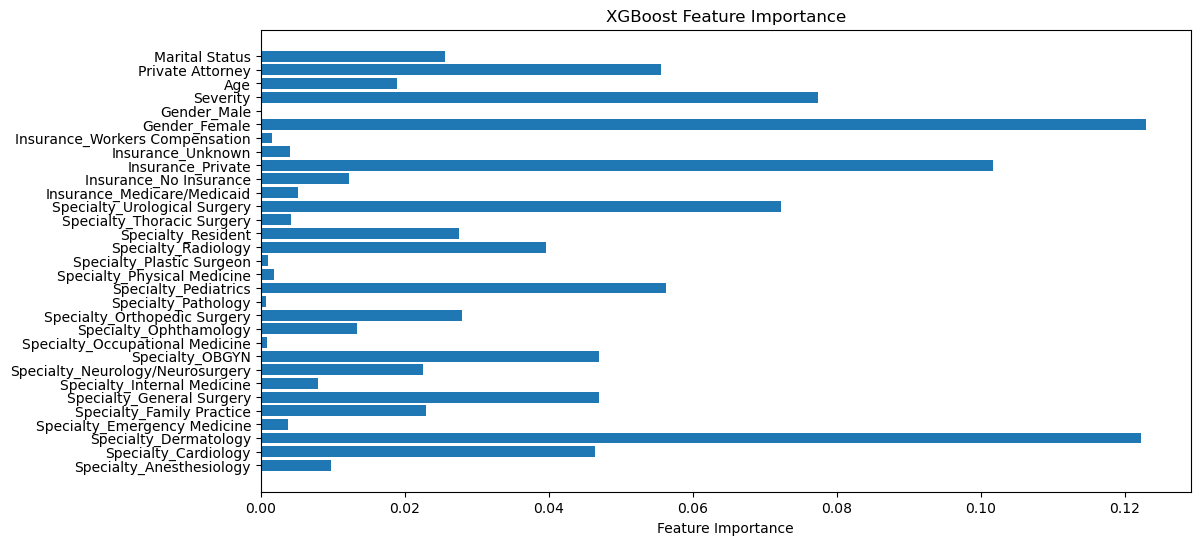

In [ ]:
# Feature Importance Plot for XGBoost
best_xgb = xgb_grid.best_estimator_
xgb_importance = best_xgb.feature_importances_

plt.figure(figsize=(12, 6))
plt.barh(transformed_feature_names, xgb_importance)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

## CatBoosting Regressor

In [ ]:
cat_model = CatBoostRegressor(depth=8, iterations=500, learning_rate=0.1, verbose=False)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the CatBoost Regressor model after hyper parameter tuning is %.2f" %score)

Accuracy of the CatBoost Regressor model after hyper parameter tuning is 64.74


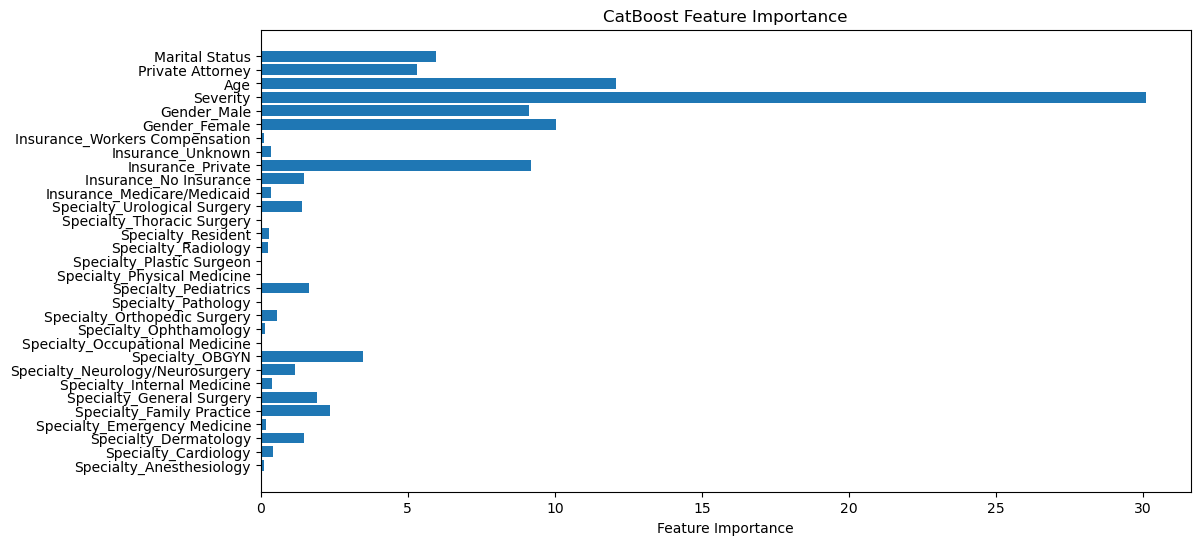

In [ ]:
# Get feature importance from the best CatBoost model
best_cat = cat_grid.best_estimator_
cat_importance = best_cat.get_feature_importance()

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(transformed_feature_names, cat_importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

## Key Observations from the XGBoost Feature Importance Plot:

In the XGBoost plot, the most important features are:
1. Severity – The most significant predictor in the model.
              Higher severity ratings likely correlate with higher claim amounts.
2. Specialty_Emergency Medicine – Physicians practicing emergency medicine have the highest impact on claim amounts.
                                This makes sense as emergency cases often involve higher-risk procedures.
3. Age – Age of the claimant is another important factor.
        Claims from older patients might involve more complex procedures and higher costs.

Other notable features include:
1. Insurance_No Insurance: Whether the patient had no insurance.
2. Private Attorney: Claimants represented by private attorneys tend to have higher claim amounts.

Insights from XGBoost Plot:
1. Medical specialty plays a crucial role in predicting claim amounts.
2. Patient characteristics such as severity of the case and age are highly influential.

## Key Observations from the CatBoost Feature Importance Plot:

In the CatBoost plot, the most important features are:
1. Severity – Again, this is the most critical predictor.
2. Age – Similar to XGBoost, the patient's age is highly important.
3. Private Attorney – The presence of a private attorney also significantly impacts claim amounts.
4. Specialty_Emergency Medicine – Emergency medicine specialists are still among the top features.

Insights from CatBoost Plot:
1. Severity is even more important in CatBoost compared to XGBoost, indicating that CatBoost places more emphasis on this feature.
2. Age and Private Attorney remain critical.
3. Specialties have a slightly reduced importance compared to XGBoost.

## Business Interpretation:

1. Severity is the most significant factor in determining claim amounts. This suggests that the extent of damage to the patient directly impacts the size of the settlement.

2. Medical Specialty also plays a critical role. Claims involving emergency medicine specialists tend to result in higher payouts, likely due to the high-risk nature of their work.

3. Age of the Claimant is an important predictor. Older patients may require more expensive procedures, leading to higher claims.

4. Legal Representation matters. Claimants represented by private attorneys are more likely to win higher settlements.

#### Difference between Actual and Predicted Values (with CatBoost)

In [ ]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
19537,56018,84609.212806,-28591.212806
44265,70790,118134.852930,-47344.852930
23642,157511,82473.608117,75037.391883
43853,19714,23909.825890,-4195.825890
65390,202842,101432.091552,101409.908448
...,...,...,...
73382,162146,194491.333989,-32345.333989
72962,59867,94010.788902,-34143.788902
30191,108392,160138.703166,-51746.703166
62849,740137,506272.942636,233864.057364
